In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

sys.path.append("..")
sys.path.append("../analyze")
sys.path.append("../measuring_volume")
sys.path.append("../common")
import pickle
from classify_seq import make_input_seq as mis

import keras_tuner as kt

type_of_l = "L2"

/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.16.1


## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

データセットからx, yを作成する

In [5]:
# [0, 1, ... 0] + temperature + eigenvalue
f1 = open("../dataset/x_initial_L2.pkl", "rb")
f2 = open("../dataset/L2_data_initial.pkl", "rb")
domain_seq_dic = pickle.load(f1)
value_dic = pickle.load(f2)
domain_lst = mis.seq_lst(f"../conf/input_seq_{type_of_l}.csv")

f1.close()
f2.close()

x_data = []
y_data = []

for key in domain_seq_dic:
    new_x = []
    for domain in domain_lst:
        new_x.append(domain_seq_dic[key]["domain"][domain])
    new_x.append(int(key[0]))
    new_x.append(float(domain_seq_dic[key]['eigenValue_2']))
    x_data.append(new_x)
    y_data.append(value_dic[(key[0], key[1][1:])]['mean_volume'])

print(x_data)
print(y_data)



[[0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 277, 1.0001986055322765], [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-L20n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [7]:
def build_model():
    
    # model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    # tf.keras.layers.Dense(1) 
    # ])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', name="layer1"), # units=128 : 出力空間の次元数
    tf.keras.layers.Dense(128, activation='relu', name="layer2"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer3"), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer4"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer5"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [8]:
model = build_model()

/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 258)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │        33,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,793 (194.50 KB)

 Trainable params: 49,793 (194.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 258)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [11]:
print(example_result)

[[-11.337956 ]
 [ -8.9802   ]
 [-10.2433815]
 [ -9.208618 ]
 [-11.576565 ]
 [ -9.030628 ]
 [-10.978818 ]
 [-10.9238   ]
 [-10.603497 ]
 [-10.68414  ]]


In [12]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 100 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,2.952637,1.348926,2.952637,2.514611,1.402276,2.514611,95
96,2.702052,1.379965,2.702052,2.600514,1.443137,2.600514,96
97,2.905403,1.477335,2.905403,2.730263,1.413599,2.730263,97
98,2.878958,1.368386,2.878958,2.624069,1.403318,2.624069,98
99,2.777801,1.470910,2.777801,2.554027,1.433592,2.554027,99


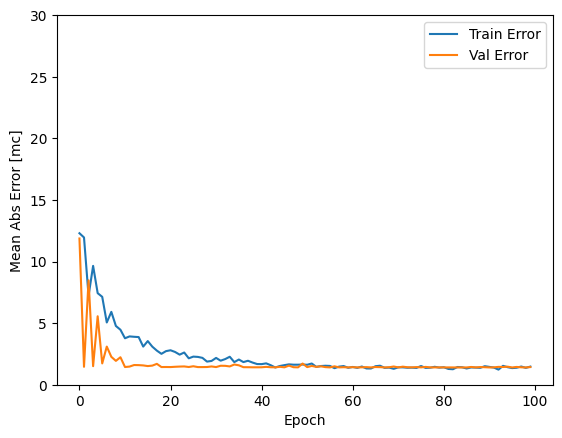

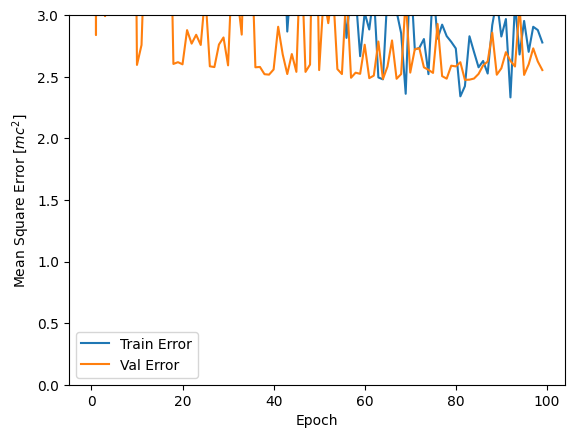

In [14]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


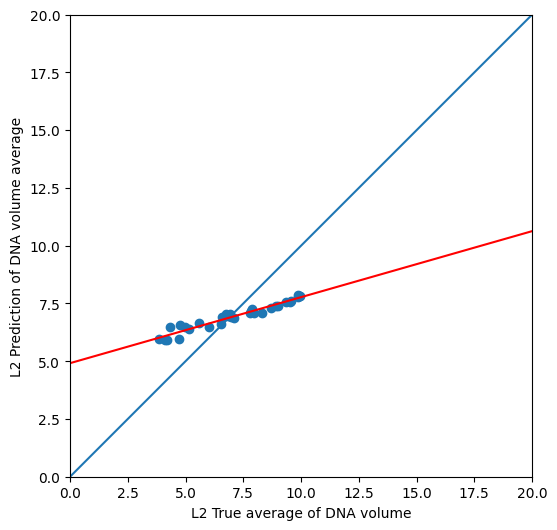

In [15]:
test_predictions = model.predict(x_test).flatten()
res = linregress(y_test, test_predictions)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('L2 True average of DNA volume')
plt.ylabel('L2 Prediction of DNA volume average')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
_ = plt.plot([0,20], [0,20])

plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

# normalizer 学習前

In [18]:
model.save('../saved_model/L2_initial_eigen.keras')

In [19]:
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras 
import tensorflow as tf
import pandas as pd

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
def randomforest_regressor(x, y, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    return regr.score(x_test, y_test)


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor
def extratrees_regressor(x, y, x_train, x_test, y_train, y_test):
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    x_train, y_train)
    return reg.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def gradientboosting_regressor(X_train, X_test, y_train, y_test):
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
def stacking_regressor(X_train, X_test, y_train, y_test):
    X, y = load_diabetes(return_X_y=True)
    estimators = [
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42))
    ]
    reg = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=10,
                                            random_state=42)
    )
    ref = reg.fit(X_train, y_train)
    return ref.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
def voting_regressor(X, y, x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    er.predict(X)
    return er.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def histgradientboosting_regressor(X, y, x_train, x_test, y_train, y_test):
    # est = HistGradientBoostingRegressor().fit(X, y)
    est = HistGradientBoostingRegressor().fit(x_train, y_train)
    return est.score(x_test, y_test)

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L2_6_model'):
    #y_data = np.concatenate([np.array(y_train),np.array(y_test)])
    #print(type(y_data), y_data.shape)
    #min_val = y_data.min()
    #max_val = y_data.max()
    #y_train = (y_train - min_val)/(max_val - min_val)
    #y_test = (y_test - min_val)/(max_val - min_val)
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()
    for i in range(len(y_test)):
        print(f"Expected {y_test[i]} and got {test_predictions[i]}")

    #mse = tf.keras.losses.MeanSquaredError()
    u = ((y_test-test_predictions)**2).sum()
    v = ((y_test - y_test.mean()) ** 2).sum()

    return 1.0 - u/v #mse(y_test,test_predictions).numpy()

def new_neural_mse(x, y, x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L2_6_model'):

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()

    mse = tf.keras.losses.MeanSquaredError()

    return mse(y_test,test_predictions).numpy()


In [21]:
x = x_data
y = y_data

extratrees = extratrees_regressor(x, y, x_train, x_test, y_train, y_test)
randomforest = randomforest_regressor(x, y, x_train, x_test, y_train, y_test) 
gradientboosting = gradientboosting_regressor(x_train, x_test, y_train, y_test)
stacking = stacking_regressor(x_train, x_test, y_train, y_test)
voting = voting_regressor(x, y, x_train, x_test, y_train, y_test)
histgradientboosting = histgradientboosting_regressor(x, y, x_train, x_test, y_train, y_test)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L2_initial_eigen.keras')


/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/P

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Expected 6.925616664928446 and got 7.02984094619751
Expected 9.872697011734937 and got 7.862499237060547
Expected 9.333410668377832 and got 7.564615726470947
Expected 5.141046075784281 and got 6.402063369750977
Expected 4.713338186862077 and got 5.948012828826904
Expected 6.946897856360019 and got 6.902976989746094
Expected 8.67961649870945 and got 7.315961837768555
Expected 7.9785023923869245 and got 7.092520236968994
Expected 6.537276438583971 and got 6.619447708129883
Expected 7.88815097155871 and got 7.259755611419678
Expected 7.106069424382819 and got 6.850597858428955
Expected 4.966989995949418 and got 6.476158142089844
Expected 6.598352778755587 and got 6.9275431632995605
Expected 9.525997154505019 and got 7.555854320526123
Expected 9.953287373825704 and got 7.830667018890381
Expected 3.844305181399501 and got 5.972314357757568
Expected 6.819514981663542 and got 6.959672451019287
Expected 8.927599313553035 and got 7.398271560668945
Expected 

In [22]:
lst = []
lst.append(["extratrees" ,extratrees])
lst.append(["randomforest", randomforest])
lst.append(["gradientboosting", gradientboosting])
lst.append(["stacking", stacking])
lst.append(["voting", voting])
lst.append(["histgradientboosting", histgradientboosting])
lst.append(["neural network", neural_mse_score])
    
df = pd.DataFrame(data=lst,columns=['regressor', 'score'])
print(df)



              regressor     score
0            extratrees  0.950475
1          randomforest  0.967552
2      gradientboosting  0.973346
3              stacking  0.952884
4                voting  0.968649
5  histgradientboosting  0.952314
6        neural network  0.472474


In [24]:
def bagging_regressor(estimator, x_train, x_test, y_train, y_test):
    # BaggingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
    er = BaggingRegressor(estimator=estimator, n_estimators=10, random_state=1)
    er.fit(x_train, y_train)
    
    # モデルのスコアを計算して返す
    score = er.score(x_test, y_test)
    
    return score

In [26]:
x = x_data
y = y_data


# 各種モデルのバギングを実行
extratrees = bagging_regressor(ExtraTreesRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("ExtraTreesRegressor with Bagging Score:", extratrees)

randomforest = bagging_regressor(RandomForestRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("RandomForestRegressor with Bagging Score:", randomforest)

gradientboosting = bagging_regressor(GradientBoostingRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("GradientBoostingRegressor with Bagging Score:", gradientboosting)

# スタッキングの例
estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=1)),
    ('et', ExtraTreesRegressor(n_estimators=10, random_state=1))
]
stacking_estimator = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking = bagging_regressor(stacking_estimator, x_train, x_test, y_train, y_test)
print("StackingRegressor with Bagging Score:", stacking)

histgradientboosting = bagging_regressor(HistGradientBoostingRegressor(random_state=1), x_train, x_test, y_train, y_test)
print("HistGradientBoostingRegressor with Bagging Score:", histgradientboosting)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L2_initial_eigen.keras')


ExtraTreesRegressor with Bagging Score: 0.9637430021743522
RandomForestRegressor with Bagging Score: 0.9660877331271321
GradientBoostingRegressor with Bagging Score: 0.8649938604054516
StackingRegressor with Bagging Score: 0.9671216514220278
HistGradientBoostingRegressor with Bagging Score: 0.9535658558866084
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Expected 6.925616664928446 and got 7.02984094619751
Expected 9.872697011734937 and got 7.862499237060547
Expected 9.333410668377832 and got 7.564615726470947
Expected 5.141046075784281 and got 6.402063369750977
Expected 4.713338186862077 and got 5.948012828826904
Expected 6.946897856360019 and got 6.902976989746094
Expected 8.67961649870945 and got 7.315961837768555
Expected 7.9785023923869245 and got 7.092520236968994
Expected 6.537276438583971 and got 6.619447708129883
Expected 7.88815097155871 and got 7.259755611419678
Expected 7.106069424382819 and got 6.850597858428955
Expected 4.966989995949418 and got 6.476158142089844
Expected 6.598352

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# データ
lst = [
    ["extratrees", extratrees],
    ["randomforest", randomforest],
    ["gradientboosting", gradientboosting],
    ["stacking", stacking],
    # ["voting", voting],  # コメントアウト中
    ["histgradientboosting", histgradientboosting],
    ["neural network", neural_mse_score]
]

# データフレームの作成
df = pd.DataFrame(data=lst, columns=['regressor', 'score'])
print(df)

# PDFへの保存
pdf_path = 'regressor_scores_L2.pdf'

# プロットをPDFに保存するための設定
with PdfPages(pdf_path) as pdf:
    # データフレームをプロット
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # テーブルのスタイル設定
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.5, 1.5)

    # セルのスタイル設定
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('grey')
        if i == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        else:  # Data cells
            cell.set_facecolor('#f1f1f2')
        cell.set_height(0.05)
        cell.set_width(0.2)
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"DataFrame has been saved as {pdf_path}")


              regressor     score
0            extratrees  0.963743
1          randomforest  0.966088
2      gradientboosting  0.864994
3              stacking  0.967122
4  histgradientboosting  0.953566
5        neural network  0.472474
DataFrame has been saved as regressor_scores_L2.pdf


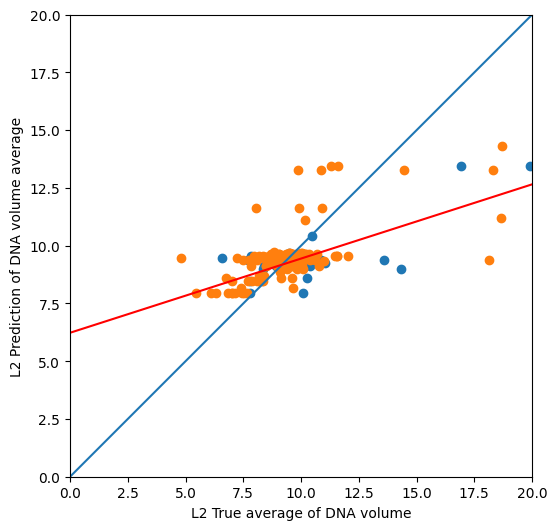

In [23]:
def randomforest_regressor(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2,n_estimators=10)
    regr.fit(x_train, y_train)

    test_predictions = regr.predict(x_test).flatten()
    train_predictions = regr.predict(x_train).flatten()
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L2 True average of DNA volume')
    plt.ylabel('L2 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    with open('../saved_model/randomforest_model_L2.pkl', 'wb') as f:
        pickle.dump(regr, f)
randomforest_regressor(x_train, x_test, y_train, y_test)

In [24]:
def voting_regressor(x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L2 True average of DNA volume')
    plt.ylabel('L2 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    #with open('../saved_model/randomforest_model_L2.pkl', 'wb') as f:
    #    pickle.dump(regr, f)
voting_regressor(x_train, x_test, y_train, y_test)

AttributeError: 'NoneType' object has no attribute 'split'

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)

            # Save the model
    with open('../saved_model/bagging_model_L2_initial.pkl', 'wb') as f:
        pickle.dump(er, f)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L2 True average of DNA volume')
    plt.ylabel('L2 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    print(er.score(x_test, y_test))

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

0.41571280803693056


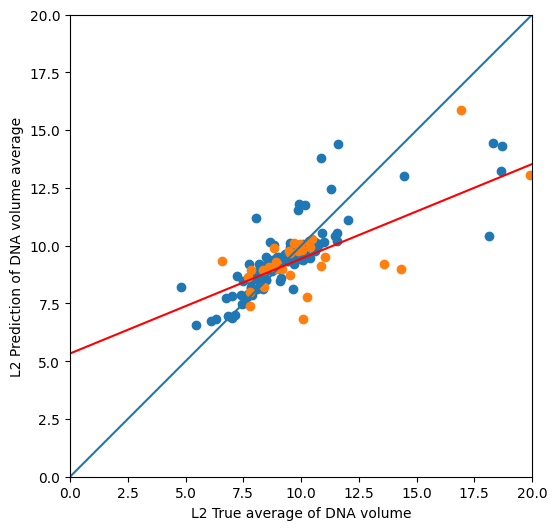

In [28]:
bagging_regressor(x_train, x_test, y_train, y_test)